In [93]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [94]:
%%R

#install.packages("tibble")
#install.packages("dplyr")
#install.packages(ggplot2)
#install.packages("caret")
#install.packages("glmnet")

library(tibble)
library(dplyr)
library(ggplot2)
library(caret)
library(pROC)
library(ROSE)
library(glmnet)

In [95]:
%%R

binary_driving_mode <- function (df_chassis) {
    result <- ifelse(df_chassis$drivingMode == "COMPLETE_AUTO_DRIVE", 1, 0)

    return(result)
}


merge_chassis_pose <- function (df_chassis, df_pose) {
    
    
    df_chassis <- df_chassis[order(df_chassis$time), ]
    df_pose <- df_pose[order(df_pose$time), ]
    
    #make sure data is sorted by time fist

    chassis_time_arr <- df_chassis$time
    pose_time_arr <- df_pose$time

    matched_vector <- c()

    for (chassis_time in chassis_time_arr) {
        abs_time_diff_arr <- abs(pose_time_arr - chassis_time)

        min_index <-  which(abs_time_diff_arr == min(abs_time_diff_arr))
        
        matched_vector <-  c(matched_vector, pose_time_arr[min_index])
    }



    #df_chassis$matched <- df_pose$time[which(abs(pose_time_arr - df_chassis$time) == min(abs(pose_time_arr - df_chassis$time)))]
    df_chassis$matched <-  matched_vector
    df_pose$matched <-  df_pose$time


    return (list(df_chassis = df_chassis, df_pose = df_pose))


}

latlongStdDev <- function(df_pose){
    x <- df_pose["latitudeStdDev"]
    y <- df_pose["longitudeStdDev"]
    r <- sqrt(x^2 + y^2)

    return(r)

}

In [96]:
%%R
# Defining GMIDs for Red Routes
# Am creating a list of GMIDs for processing
red_route_gmIDs  <- c(
     '61b12e7a-f234-11ee-bb33-fb353e7798cd',
'fcc6fcd2-f013-11ee-b966-fb353e7798cd',
'05c7c824-cab8-11ee-aa4d-1d66adf2f0c7',
'211bdb36-f0da-11ee-ba1b-fb353e7798cd',
'868de15e-f3b3-11ee-bb4e-fb353e7798cd',
'72a03d4a-efe9-11ee-b966-fb353e7798cd',
'7fb7b9c0-c881-11ee-a7fc-dd032dba19e8',
'96f7a614-f549-11ee-8afa-cb629b0d53e6',
'1bbbfbae-c839-11ee-a7fc-dd032dba19e8',
'622bd2e8-f0e4-11ee-ba1f-fb353e7798cd',
'9798fe24-f143-11ee-ba78-fb353e7798cd',
'88dd6fbe-f224-11ee-bb21-fb353e7798cd',
'c9c6856c-d33c-11ee-b437-336917683bb8',
'd12cd1c4-caec-11ee-909c-e1dc60cf66f9',
'817d6848-efb6-11ee-b966-fb353e7798cd',
'1b6aca0e-efdf-11ee-b966-fb353e7798cd',
'41b67a28-f52f-11ee-8afa-cb629b0d53e6',
'fc211bb2-efca-11ee-b966-fb353e7798cd',
'84d96f18-f214-11ee-bb13-fb353e7798cd',
'fe973c9c-f53c-11ee-8afa-cb629b0d53e6',
'3151e9e2-eff3-11ee-b966-fb353e7798cd',
'c0555ef0-f50f-11ee-8afa-cb629b0d53e6',
'f711e68e-f0e1-11ee-ba1f-fb353e7798cd',
'c338788a-d324-11ee-b437-336917683bb8',
'd21965e6-f0fa-11ee-ba37-fb353e7798cd',
'88a68dd8-eef9-11ee-9385-ef789ffde1d3',
'f41cbd44-eff8-11ee-b966-fb353e7798cd',
'43a1a35e-f362-11ee-bb4e-fb353e7798cd',
'6d2ea45a-c839-11ee-a7fc-dd032dba19e8',
'01e65360-efd4-11ee-b966-fb353e7798cd',
'7cbd932e-f244-11ee-bb3f-fb353e7798cd',
'65cfbfd6-f396-11ee-bb4e-fb353e7798cd',
'94c53148-eeed-11ee-9385-ef789ffde1d3',
'fd1ab258-efa7-11ee-b966-fb353e7798cd',
'e7b934a8-ef1a-11ee-9385-ef789ffde1d3',
'de933de8-f112-11ee-ba4d-fb353e7798cd',
'd3698592-ef9d-11ee-b966-fb353e7798cd',
'dd72fdec-f0cf-11ee-ba0d-fb353e7798cd',
'b82476fe-f1f3-11ee-baff-fb353e7798cd',
'f755cf60-f132-11ee-ba6d-fb353e7798cd',
'853ef120-cad3-11ee-909c-e1dc60cf66f9',
'f0eebb6a-f0dc-11ee-ba1e-fb353e7798cd',
'cf831f42-f353-11ee-bb4e-fb353e7798cd',
'ecebb942-f162-11ee-ba97-fb353e7798cd',
'219f7eb8-ef87-11ee-b966-fb353e7798cd',
'd24820c8-f197-11ee-babe-fb353e7798cd',
'3d2d29ec-ef95-11ee-b966-fb353e7798cd',
'457dc5ee-f02a-11ee-b966-fb353e7798cd',
'2462c9d0-eecd-11ee-9385-ef789ffde1d3',
'51ef6da6-ca9f-11ee-909c-e1dc60cf66f9',
'c25271be-f3a4-11ee-bb4e-fb353e7798cd',
'8347b862-efad-11ee-b966-fb353e7798cd',
'8dbbbf1c-f0ef-11ee-ba29-fb353e7798cd',
'9189a2a8-f121-11ee-ba5b-fb353e7798cd',
'8fa6fe80-c869-11ee-a7fc-dd032dba19e8',
'35518ec4-f153-11ee-ba88-fb353e7798cd',
'2f95c748-f009-11ee-b966-fb353e7798cd',
'8437f77a-cab7-11ee-909c-e1dc60cf66f9',
'2a61b8a8-f528-11ee-8afa-cb629b0d53e6',
'5a4bccf4-effe-11ee-b966-fb353e7798cd'
)

In [97]:
%%R
# Initialize an empty tibble
df_merged <- tibble()

# Loop through each gmID
for (id in red_route_gmIDs) {
  print(id)
  
  # Update the file paths with the correct full paths
  temp_chassis_path <- sprintf(
    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_canbus_chassis/%s_apollo_canbus_chassis.csv",
    id, id
  )
  temp_pose_path <- sprintf(
    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_sensor_gnss_best_pose/%s_apollo_sensor_gnss_best_pose.csv",
    id, id
  )

  # Check if the files exist
  if (file.exists(temp_chassis_path) && file.exists(temp_pose_path)) {
    # Read the files
    temp_chassis <- as_tibble(read.csv(temp_chassis_path))
    temp_pose <- as_tibble(read.csv(temp_pose_path))
    
    # Process the data
    r <- latlongStdDev(temp_pose)
    temp_pose["latlongStdDev"] <- r
    
    results <- merge_chassis_pose(temp_chassis, temp_pose)
    result_full <- full_join(results$df_chassis, results$df_pose, by = "matched")
    
    # Add binary driving mode
    result_full$binaryDrivingMode <- binary_driving_mode(result_full)
    
    # Append to df_merged
    df_merged <- bind_rows(df_merged, result_full)
  } else {
    warning(sprintf("Files not found for gmID: %s", id))
  }
}

print("Done loading data")

[1] "61b12e7a-f234-11ee-bb33-fb353e7798cd"
[1] "fcc6fcd2-f013-11ee-b966-fb353e7798cd"
[1] "05c7c824-cab8-11ee-aa4d-1d66adf2f0c7"
[1] "211bdb36-f0da-11ee-ba1b-fb353e7798cd"
[1] "868de15e-f3b3-11ee-bb4e-fb353e7798cd"
[1] "72a03d4a-efe9-11ee-b966-fb353e7798cd"
[1] "7fb7b9c0-c881-11ee-a7fc-dd032dba19e8"
[1] "96f7a614-f549-11ee-8afa-cb629b0d53e6"
[1] "1bbbfbae-c839-11ee-a7fc-dd032dba19e8"
[1] "622bd2e8-f0e4-11ee-ba1f-fb353e7798cd"
[1] "9798fe24-f143-11ee-ba78-fb353e7798cd"
[1] "88dd6fbe-f224-11ee-bb21-fb353e7798cd"
[1] "c9c6856c-d33c-11ee-b437-336917683bb8"
[1] "d12cd1c4-caec-11ee-909c-e1dc60cf66f9"
[1] "817d6848-efb6-11ee-b966-fb353e7798cd"
[1] "1b6aca0e-efdf-11ee-b966-fb353e7798cd"
[1] "41b67a28-f52f-11ee-8afa-cb629b0d53e6"
[1] "fc211bb2-efca-11ee-b966-fb353e7798cd"
[1] "84d96f18-f214-11ee-bb13-fb353e7798cd"
[1] "fe973c9c-f53c-11ee-8afa-cb629b0d53e6"
[1] "3151e9e2-eff3-11ee-b966-fb353e7798cd"
[1] "c0555ef0-f50f-11ee-8afa-cb629b0d53e6"
[1] "f711e68e-f0e1-11ee-ba1f-fb353e7798cd"
[1] "c33878

In [98]:
%%R
# Load required library
library(dplyr)

# Split GMIDs into Training and Testing Sets
training_gmIDs <- red_route_gmIDs[1:55]  # First 55 GMIDs (80%)
testing_gmIDs <- red_route_gmIDs[56:60] # Last 5 GMIDs

# Filter df_merged for training and testing data based on GMIDs
train_data <- df_merged %>% filter(groupMetadataID.x %in% training_gmIDs)
test_data <- df_merged %>% filter(groupMetadataID.x %in% testing_gmIDs)

# Check the number of rows in each dataset
print(paste("Training data rows:", nrow(train_data)))
print(paste("Testing data rows:", nrow(test_data)))

# Verify if test_data is not empty
if (nrow(test_data) == 0) {
  print("Error: test_data is empty. Check GMID filtering.")
}


[1] "Training data rows: 3001134"
[1] "Testing data rows: 293396"


In [99]:
%%R
# Train a Logistic Regression Model
model <- glm(
  binaryDrivingMode ~ speedMps + throttlePercentage + brakePercentage + steeringPercentage + latlongStdDev,
  data = train_data,
  family = binomial
)

summary(model)


Call:
glm(formula = binaryDrivingMode ~ speedMps + throttlePercentage + 
    brakePercentage + steeringPercentage + latlongStdDev, family = binomial, 
    data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2500   0.6514   0.6974   0.7304   3.4205  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         0.8500473  0.0050512  168.28  < 2e-16 ***
speedMps            0.0204820  0.0002559   80.04  < 2e-16 ***
throttlePercentage  0.0020149  0.0001203   16.75  < 2e-16 ***
brakePercentage     0.0009052  0.0001596    5.67 1.42e-08 ***
steeringPercentage  0.0145121  0.0001556   93.26  < 2e-16 ***
latlongStdDev      -0.0564894  0.0007851  -71.95  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 3246295  on 3001133  degrees of freedom
Residual deviance: 3212697  on 3001128  degrees of freedom
AIC: 3212709

Numb

In [101]:
%%R
 # Predict on the test set
 predictions <- predict(model, test_data, type = "response")

 #Covert probabilities to binary classes (0 or 1)
 predicted_classes <- ifelse(predictions > 0.5, 1, 0)

 # Calculate accuracy
 accuracy <- mean(predicted_classes == test_data$binaryDrivingMode)

 # Print the accuracy
print(paste("Accuracy:", accuracy))

[1] "Accuracy: 0.813450081119034"


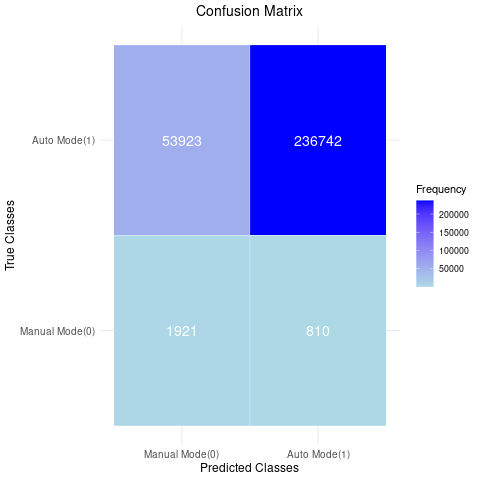

In [102]:
%%R
# Load required libraries
library(ggplot2)
library(caret)

# Map the values to labels (1 -> "Auto_mode", 0 -> "Manual")
predicted_classes_labeled <- factor(predicted_classes, levels = c(0,1), labels = c("Manual Mode(0)", "Auto Mode(1)"))
actual_classes_labeled <- factor (test_data$binaryDrivingMode, levels = c(0,1), labels = c("Manual Mode(0)", "Auto Mode(1)"))

# Generate the confusion matrix
cm <- confusionMatrix(predicted_classes_labeled, actual_classes_labeled)
cm_table <- as.data.frame(cm$table)

# Rename columns for better understanding
colnames(cm_table) <- c("Actual", "Predicted", "Frequency")

# Create the colored confusion matrix plot
ggplot(cm_table, aes(x = Predicted, y = Actual, fill = Frequency)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "lightblue", high = "blue", name = "Frequency") +
  geom_text(aes(label = Frequency), color = "white", size = 5) +
  labs(title = "Confusion Matrix", x = "Predicted Classes", y = "True Classes") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, size = 14),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

Area under the curve: 0.6816


Setting levels: control = 0, case = 1
Setting direction: controls < cases


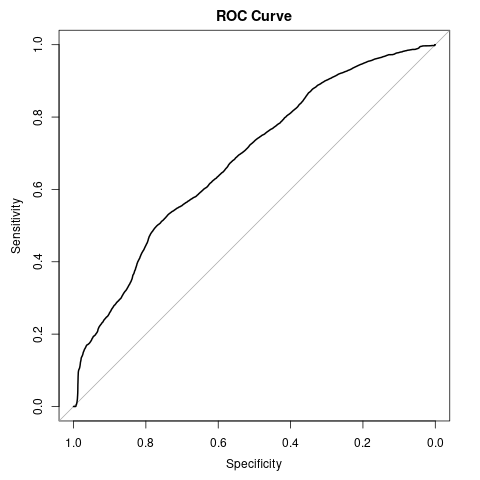

In [103]:
%%R

library(pROC)
roc_obj <- roc(test_data$binaryDrivingMode, predictions)
plot(roc_obj, main = "ROC Curve")
auc(roc_obj)

In [104]:
%%R

#Manually calculating the confusion matrix values
TP <- 236742
FP <- 810
FN <- 53923
TN <- 1921

# Calculate Metrics
accuracy <- (TP + TN) / (TP + TN + FP + FN)
precision <- TP / (TP + FP)
recall <- TP / (TP + FN)
#Print Metrics
cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")

Accuracy: 0.8134501 
Precision: 0.9965902 
Recall: 0.814484 


In [105]:
%%R

# Manually calculating the confusion matrix values
TP <- 236742
FP <- 810
FN <- 53923
TN <- 1921

# Calculate Metrics
tpr <- TP / (TP + FN) # Sensitivity
tnr <- TN / (TN + FP) # Specificity 

# Calculate Balance Accuracy
balanced_accuracy <- (tpr + tnr) / 2

#Print results
print(paste("True Positive Rate (TPR):", round(tpr, 4)))
print(paste("True Negative Rate (TPR):", round(tnr, 4)))
print(paste("Balance Accuracy:", round(balanced_accuracy, 4)))

[1] "True Positive Rate (TPR): 0.8145"
[1] "True Negative Rate (TPR): 0.7034"
[1] "Balance Accuracy: 0.7589"


In [106]:
%%R
# Filter actual manual mode locations
actual_manual_mode <- test_data[test_data$binaryDrivingMode == 0, ]

# Extract actual manual mode coordinates
actual_latitudes <- actual_manual_mode$latitude
actual_longitudes <- actual_manual_mode$longitude

# Filter test data where the model predicted Manual Mode (0)
predicted_manual_mode <- test_data[predicted_classes == 0, ]

# Extract predicted manual mode coordinates
predicted_latitudes <- predicted_manual_mode$latitude
predicted_longitudes <- predicted_manual_mode$longitude

# Ensure both actual and predicted lists have the same length
min_length <- min(length(actual_latitudes), length(predicted_latitudes))
actual_latitudes <- actual_latitudes[1:min_length]
actual_longitudes <- actual_longitudes[1:min_length]
predicted_latitudes <- predicted_latitudes[1:min_length]
predicted_longitudes <- predicted_longitudes[1:min_length]

# Create a data frame with actual and predicted manual mode locations
manual_mode_comparison <- data.frame(
    actual_latitude = actual_latitudes,
    actual_longitude = actual_longitudes,
    predicted_latitude = predicted_latitudes,
    predicted_longitude = predicted_longitudes
)

# Display first few rows to verify
head(manual_mode_comparison)

  actual_latitude actual_longitude predicted_latitude predicted_longitude
1        39.36466        -82.10312           39.36438            -82.1033
2        39.36466        -82.10312           39.36438            -82.1033
3        39.36466        -82.10312           39.36438            -82.1033
4        39.36466        -82.10312           39.36438            -82.1033
5        39.36466        -82.10312           39.36438            -82.1033
6        39.36466        -82.10312           39.36438            -82.1033


In [107]:
import rpy2.robjects as robjects
import pandas as pd
from rpy2.robjects import pandas2ri

# Activate automatic pandas conversion
pandas2ri.activate()

# Convert R DataFrame to Pandas using the correct approach
manual_mode_comparison_r = robjects.globalenv["manual_mode_comparison"]
manual_mode_comparison_py = pandas2ri.rpy2py(manual_mode_comparison_r)

# Display first few rows
print(manual_mode_comparison_py.head())

# Rename dataframe for clarity
df = manual_mode_comparison_py

   actual_latitude  actual_longitude  predicted_latitude  predicted_longitude
1        39.364661        -82.103119           39.364376           -82.103303
2        39.364661        -82.103119           39.364376           -82.103303
3        39.364661        -82.103119           39.364376           -82.103303
4        39.364661        -82.103119           39.364376           -82.103303
5        39.364661        -82.103119           39.364376           -82.103303


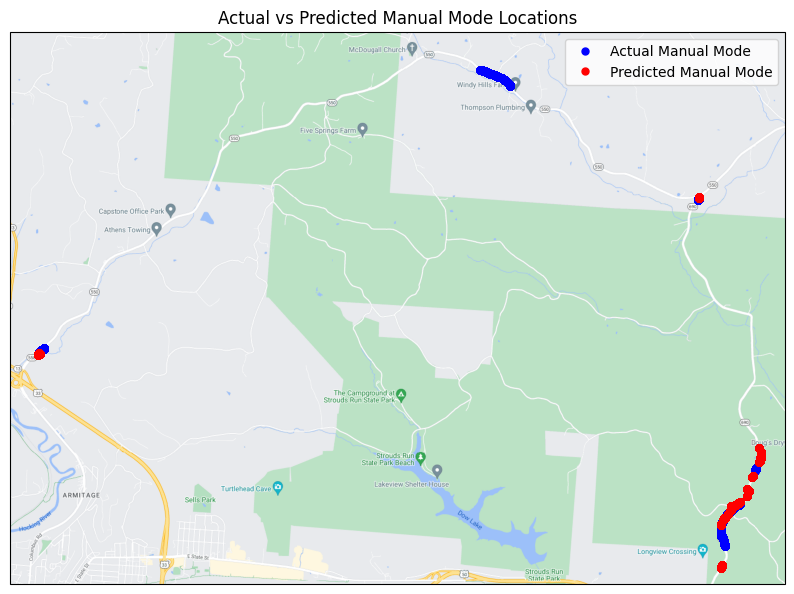

In [108]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles
import matplotlib.pyplot as plt

# Define plot size
plt.figure(figsize=(10, 10))

# Get min and max latitude/longitude
minLat = df['actual_latitude'].min()
maxLat = df['actual_latitude'].max()
minLon = df['actual_longitude'].min()
maxLon = df['actual_longitude'].max()

# Define expansion coefficient to avoid edge cutoff
expansion_coeff = 0.005

# Load street map
street_map = GoogleTiles(style='street')

# Create plot with the street map
ax = plt.axes(projection=street_map.crs)
ax.set_extent(
    [minLon - expansion_coeff, maxLon + expansion_coeff,
     minLat - expansion_coeff, maxLat + expansion_coeff],
    ccrs.PlateCarree()
)

# Add map image
ax.add_image(street_map, 14)

# Extract actual and predicted manual mode locations
true_manual_lat = df['actual_latitude']
true_manual_lon = df['actual_longitude']

pred_manual_lat = df['predicted_latitude']
pred_manual_lon = df['predicted_longitude']

# Plot actual manual mode points (Blue)
plt.plot(true_manual_lon, true_manual_lat, 
         marker='o', ls='', color='blue', ms=5, 
         label='Actual Manual Mode', transform=ccrs.PlateCarree())

# Plot predicted manual mode points (Red)
plt.plot(pred_manual_lon, pred_manual_lat, 
         marker='o', ls='', color='red', ms=5, 
         label='Predicted Manual Mode', transform=ccrs.PlateCarree())

# Add title and legend
plt.title('Actual vs Predicted Manual Mode Locations')
plt.legend()

# Show the plot
plt.show()

In [109]:
%%R

# Filter data where the actual driving mode was Auto Mode (1)
actual_auto_mode <- df_merged %>%
  filter(binaryDrivingMode == 1)

# Extract actual latitude and longitude
actual_latitudes <- actual_auto_mode$latitude
actual_longitudes <- actual_auto_mode$longitude

In [110]:
%%R

# Filter test data where the model predicted Auto Mode (1)
predicted_auto_mode <- test_data[predicted_classes == 1,]

# Extract predicted latitude and longitude
predicted_latitudes <- predicted_auto_mode$latitude
predicted_longitudes <- predicted_auto_mode$longitude

In [111]:
%%R
# Ensuring actual_longitudes has the same length as actual_latitudes
actual_longitudes <- actual_longitudes[1:length(actual_latitudes)]

In [112]:
%%R
# Ensure actual data is filtered properly to match predictions
actual_auto_mode <- test_data[test_data$binaryDrivingMode == 1, ]

# Extract matched actual coordinates
actual_latitudes <- actual_auto_mode$latitude
actual_longitudes <- actual_auto_mode$longitude

# Ensure both actual and predicted lists have the same length
min_length <- min(length(actual_latitudes), length(predicted_latitudes))

actual_latitudes <- actual_latitudes[1:min_length]
actual_longitudes <- actual_longitudes[1:min_length]
predicted_latitudes <- predicted_latitudes[1:min_length]
predicted_longitudes <- predicted_longitudes[1:min_length]

In [113]:
%%R

auto_mode_comparison <- data.frame(
  actual_latitude = actual_latitudes,
  actual_longitude = actual_longitudes,
  predicted_latitude = predicted_latitudes,
  predicted_longitude = predicted_longitudes
)

# Display first few rows to verify
head(auto_mode_comparison)

  actual_latitude actual_longitude predicted_latitude predicted_longitude
1        39.36526        -82.10222           39.36466           -82.10312
2        39.36526        -82.10222           39.36466           -82.10312
3        39.36526        -82.10222           39.36466           -82.10312
4        39.36526        -82.10222           39.36466           -82.10312
5        39.36535        -82.10209           39.36466           -82.10312
6        39.36535        -82.10209           39.36466           -82.10312


In [114]:
import rpy2.robjects as robjects
import pandas as pd
from rpy2.robjects import pandas2ri

# Activate automatic pandas conversion
pandas2ri.activate()

# Convert R DataFrame to Pandas using the correct approach
auto_mode_comparison_r = robjects.globalenv["auto_mode_comparison"]
auto_mode_comparison_py = pandas2ri.rpy2py(auto_mode_comparison_r)

# Display first few rows
print(auto_mode_comparison_py.head())

   actual_latitude  actual_longitude  predicted_latitude  predicted_longitude
1        39.365260        -82.102219           39.364661           -82.103119
2        39.365260        -82.102219           39.364661           -82.103119
3        39.365260        -82.102219           39.364661           -82.103119
4        39.365260        -82.102219           39.364661           -82.103119
5        39.365348        -82.102091           39.364661           -82.103119


(237552, 4)


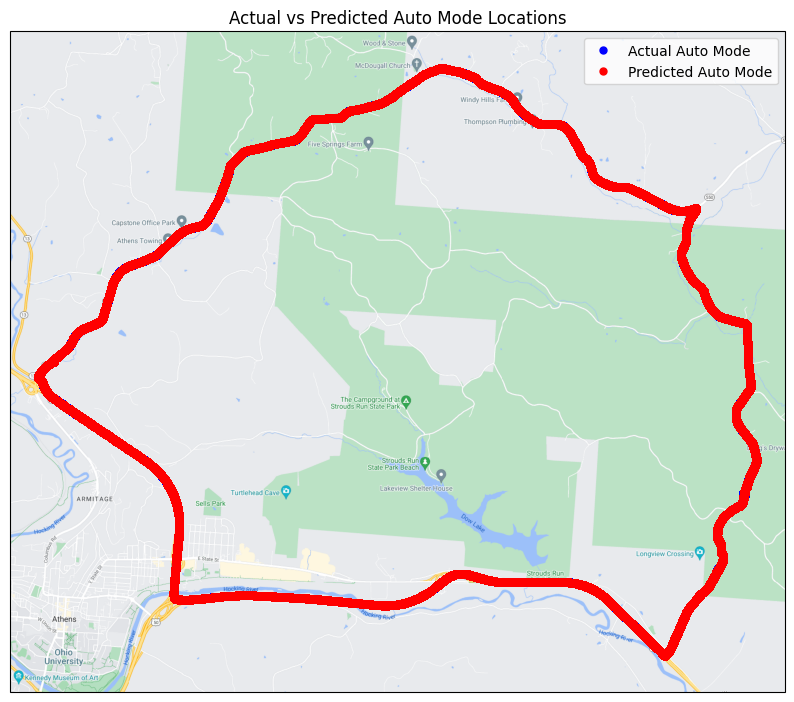

In [115]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles
import matplotlib.pyplot as plt

# Define the dataframe (renaming for clarity)
df = auto_mode_comparison_py  # Use the dataframe converted from R

# Print shape for verification
print(df.shape)

# Define plot size
plt.figure(figsize=(10, 10))

# Get min and max latitude and longitude
minLat = df['actual_latitude'].min()
maxLat = df['actual_latitude'].max()
minLon = df['actual_longitude'].min()
maxLon = df['actual_longitude'].max()

# Define expansion coefficient to avoid edge cutoff
expansion_coeff = 0.005

# Load street map
street_map = GoogleTiles(style='street')

# Create plot with the street map
ax = plt.axes(projection=street_map.crs)
ax.set_extent(
    [minLon - expansion_coeff, maxLon + expansion_coeff, 
     minLat - expansion_coeff, maxLat + expansion_coeff], 
    ccrs.PlateCarree()
)

# Add map image
ax.add_image(street_map, 14)

# Extract actual and predicted auto mode locations
true_auto_lat = df['actual_latitude']
true_auto_lon = df['actual_longitude']

pred_auto_lat = df['predicted_latitude']
pred_auto_lon = df['predicted_longitude']

# Plot actual auto mode points (Blue)
plt.plot(true_auto_lon, true_auto_lat, 
         marker='o', ls='', color='blue', ms=5, 
         label='Actual Auto Mode', transform=ccrs.PlateCarree())

# Plot predicted auto mode points (Red)
plt.plot(pred_auto_lon, pred_auto_lat, 
         marker='o', ls='', color='red', ms=5, 
         label='Predicted Auto Mode', transform=ccrs.PlateCarree())

# Add title and legend
plt.title('Actual vs Predicted Auto Mode Locations')
plt.legend()

# Show the plot
plt.show()

In [116]:
%%R

# Define the selected GMID
selected_gmID <- "2f95c748-f009-11ee-b966-fb353e7798cd"

# Ensure the column exists in test_data
if (!("groupMetadataID.x" %in% colnames(test_data))) {
    stop("Error: Column 'groupMetadataID.x' does not exist in test_data.")
}

# Convert groupMetadataID.x to character to avoid type mismatches
test_data$groupMetadataID.x <- as.character(test_data$groupMetadataID.x)

# Filter test data for the selected GMID
test_data_gmid <- test_data[test_data$groupMetadataID.x == selected_gmID, ]

# Check if filtering was successful
if (nrow(test_data_gmid) == 0) {
    stop("Error: No data found for the selected GMID.")
}

# Confirm that only one GMID is present
print(unique(test_data_gmid$groupMetadataID.x))  # Should return only one GMID

# Check the number of rows
print(nrow(test_data_gmid))  # Should be greater than 0


[1] "2f95c748-f009-11ee-b966-fb353e7798cd"
[1] 54503


In [117]:
%%R

# Ensure predicted_classes is properly indexed for the same dataset
if (length(predicted_classes) != nrow(test_data)) {
    stop("Error: Length of predicted_classes does not match the number of rows in test_data.")
}

In [118]:
%%R
# Extract rows where predicted_classes == 0 for the selected GMID
predicted_manual_mode <- test_data_gmid[which(predicted_classes[test_data$groupMetadataID.x == selected_gmID] == 0), ]

# Confirm data selection
print(nrow(predicted_manual_mode))  # Should be > 0 if successful

[1] 1704


In [119]:
%%R
# Extract actual Manual Mode coordinates
actual_latitudes <- test_data_gmid[test_data_gmid$binaryDrivingMode == 0, ]$latitude
actual_longitudes <- test_data_gmid[test_data_gmid$binaryDrivingMode == 0, ]$longitude

# Extract predicted Manual Mode coordinates
predicted_latitudes <- predicted_manual_mode$latitude
predicted_longitudes <- predicted_manual_mode$longitude

In [120]:
%%R
min_length <- min(length(actual_latitudes), length(predicted_latitudes))

actual_latitudes <- actual_latitudes[1:min_length]
actual_longitudes <- actual_longitudes[1:min_length]
predicted_latitudes <- predicted_latitudes[1:min_length]
predicted_longitudes <- predicted_longitudes[1:min_length]

# Create a dataframe with actual and predicted locations
manual_mode_comparison <- data.frame(
    actual_latitude = actual_latitudes,
    actual_longitude = actual_longitudes,
    predicted_latitude = predicted_latitudes,
    predicted_longitude = predicted_longitudes
)

# Display first few rows
print(head(manual_mode_comparison))

  actual_latitude actual_longitude predicted_latitude predicted_longitude
1        39.36436        -82.10312           39.36438            -82.1033
2        39.36436        -82.10312           39.36438            -82.1033
3        39.36436        -82.10312           39.36438            -82.1033
4        39.36436        -82.10312           39.36438            -82.1033
5        39.36436        -82.10312           39.36438            -82.1033
6        39.36436        -82.10312           39.36438            -82.1033


In [121]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

# Activate automatic conversion
pandas2ri.activate()

# Fetch the data from R
manual_mode_comparison_r = robjects.globalenv['manual_mode_comparison']

# Convert R dataframe to pandas dataframe
df = pandas2ri.rpy2py(manual_mode_comparison_r)

# Confirm data is transferred successfully
print(df.info())  
print(df.head())  # Check the first few rows

<class 'pandas.core.frame.DataFrame'>
Index: 1704 entries, 1 to 1704
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   actual_latitude      1704 non-null   float64
 1   actual_longitude     1704 non-null   float64
 2   predicted_latitude   1704 non-null   float64
 3   predicted_longitude  1704 non-null   float64
dtypes: float64(4)
memory usage: 66.6+ KB
None
   actual_latitude  actual_longitude  predicted_latitude  predicted_longitude
1        39.364361        -82.103121           39.364376           -82.103303
2        39.364361        -82.103121           39.364376           -82.103303
3        39.364361        -82.103121           39.364376           -82.103303
4        39.364361        -82.103121           39.364376           -82.103303
5        39.364361        -82.103121           39.364376           -82.103303


In [122]:
# Check for NaN values
print(df.isna().sum())

# Fill NaN values with column mean
df['predicted_latitude'].fillna(df['predicted_latitude'].mean(), inplace=True)
df['predicted_longitude'].fillna(df['predicted_longitude'].mean(), inplace=True)

# Confirm no missing values
print(df.isna().sum())  # Should show all zeros

actual_latitude        0
actual_longitude       0
predicted_latitude     0
predicted_longitude    0
dtype: int64
actual_latitude        0
actual_longitude       0
predicted_latitude     0
predicted_longitude    0
dtype: int64


/tmp/ipykernel_22671/353852284.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['predicted_latitude'].fillna(df['predicted_latitude'].mean(), inplace=True)
/tmp/ipykernel_22671/353852284.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].meth

In [123]:
# Get min and max latitude/longitude
minLat = df['actual_latitude'].min()
maxLat = df['actual_latitude'].max()
minLon = df['actual_longitude'].min()
maxLon = df['actual_longitude'].max()

# Define expansion coefficient to avoid cutting off data
expansion_coeff = 0.005

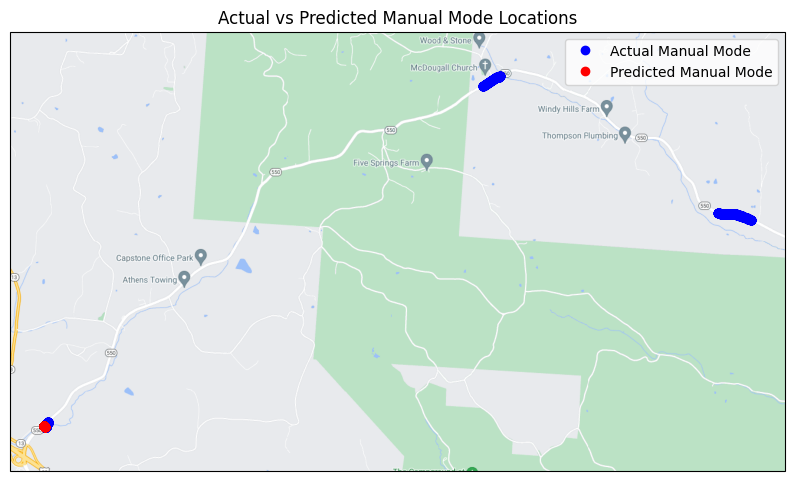

In [124]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles
import matplotlib.pyplot as plt

# Load street map
street_map = GoogleTiles(style='street')

# Create the plot with the street map
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=street_map.crs)
ax.set_extent([minLon - expansion_coeff, maxLon + expansion_coeff,
               minLat - expansion_coeff, maxLat + expansion_coeff], ccrs.PlateCarree())

# Add the map image
ax.add_image(street_map, 14)

# Plot actual manual mode points (blue)
ax.plot(df['actual_longitude'], df['actual_latitude'], marker='o', ls='', color='blue',
        label='Actual Manual Mode', transform=ccrs.PlateCarree())

# Plot predicted manual mode points (red)
ax.plot(df['predicted_longitude'], df['predicted_latitude'], marker='o', ls='', color='red',
        label='Predicted Manual Mode', transform=ccrs.PlateCarree())

# Add title and legend
plt.title('Actual vs Predicted Manual Mode Locations')
plt.legend()

# Show the plot
plt.show()